In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

from utils import data_preprocessing_util as dpu
from utils import classification_util as cu

from MLP import MLP
from nn_framework import NNFramework

import seaborn as sns
import matplotlib.pyplot as plt

# Fertility Dataset

## Preprocessing

In [101]:
data_path = r'data/fertility_diagnosis.csv'
df = pd.read_csv(data_path)
df = dpu.preprocess_fertility_dataset(df)

In [102]:
nn = NNFramework()
nn.fit_encoder(df=df, cols_to_encode=df.columns.difference(['age', 'hours_sitting']))
df_encoded = nn.encode_dataset(df)

## Parameter experiments

In [103]:
random_seed = 1038
scaling = True
oversampling = True

scaler = preprocessing.StandardScaler() if scaling else None

In [104]:
y = df_encoded['diagnosis']
X = df_encoded[df_encoded.columns.difference(['diagnosis'])]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_seed, shuffle=True, stratify=y)


In [105]:
activation_functions = ['relu', 'sigmoid']
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.5]
hidden_layer_sizes = [(5,), (32,), (16, 16), (10, 5, 5), (16, 8, 8), (64, 32, 32),]

In [106]:
methods = []

for af in activation_functions:
    for lr in learning_rates:
        for hls in hidden_layer_sizes:
            methods.append((f'MLP-{af}-{lr}-{hls}', MLP(n_iter=5000, activation_function=af, learning_rate=lr, hidden_layer_sizes=hls)))
    
pipelines = cu.define_pipelines(methods, scaler=scaler, oversampling=oversampling)

In [107]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
cv_num = 5
model_params = {}
models = {}
models_lists = {}

for model_name, pipeline in pipelines.items():
    cv_results = cross_validate(pipeline, X, y, cv=cv_num, scoring='f1_macro', return_estimator=True, n_jobs=10)

    models[model_name] = cv_results['estimator']
    model_params[model_name] = {}
    models_lists[model_name] = {}

    num_cols = ['test_score', 'fit_time', 'score_time']

    for num_col in num_cols:
        models_lists[model_name][num_col] = cv_results[num_col]
        model_params[model_name][f'{num_col}_mean'] = cv_results[num_col].mean()
        model_params[model_name][f'{num_col}_std'] = cv_results[num_col].std()
    
    model_params[model_name]['parameter_num'] = cv_results['estimator'][0][model_name].number_of_params_
    model_params[model_name]['hidden_layer_sizes'] = cv_results['estimator'][0][model_name].hidden_layer_sizes
    model_params[model_name]['activation_function'] = cv_results['estimator'][0][model_name].activation_function
    model_params[model_name]['learning_rate'] = cv_results['estimator'][0][model_name].learning_rate
    models_lists[model_name]['converged'] = [e[model_name].converged_ for e in cv_results['estimator']]
    models_lists[model_name]['validation_losses'] = [e[model_name].validation_losses_ for e in cv_results['estimator']]
    models_lists[model_name]['training_losses'] = [e[model_name].training_losses_ for e in cv_results['estimator']]
    model_params[model_name]['num_iter'] = np.array(list([len(e[model_name].training_losses_) for e in cv_results['estimator']])).mean()

    print(model_name)
    print(
        f"f1 scores: {models_lists[model_name]['test_score']}\n" +
        f"f1 mean: {model_params[model_name]['test_score_mean']:.3f}\n" +
        f"f1 std: {model_params[model_name]['test_score_std']:.3f}\n"
    )
    print('----------------------------------------------------------------------------------------------------')
    

MLP-relu-0.0001-(5,)
f1 scores: [0.25925926 0.52380952 0.34065934 0.2        0.375     ]
f1 mean: 0.340
f1 std: 0.111

----------------------------------------------------------------------------------------------------
MLP-relu-0.0001-(32,)
f1 scores: [0.28571429 0.64157706 0.42857143 0.52380952 0.37321937]
f1 mean: 0.451
f1 std: 0.123

----------------------------------------------------------------------------------------------------
MLP-relu-0.0001-(16, 16)
f1 scores: [0.375      0.74025974 0.39393939 0.42857143 0.39393939]
f1 mean: 0.466
f1 std: 0.138

----------------------------------------------------------------------------------------------------
MLP-relu-0.0001-(10, 5, 5)
f1 scores: [0.39393939 0.33333333 0.31034483 0.45945946 0.45945946]
f1 mean: 0.391
f1 std: 0.062

----------------------------------------------------------------------------------------------------
MLP-relu-0.0001-(16, 8, 8)
f1 scores: [0.09090909 0.09090909 0.13043478 0.45054945 0.39393939]
f1 mean: 0.231

In [1]:
df_param = pd.DataFrame(model_params).transpose()
df_param = df_param.reset_index(drop=False)
df_param = df_param.rename(columns={'index': 'model'})

# df_param.to_csv(r'results/fertility_params.csv', index=False)

In [32]:
def get_losses(df, loss_col = 'validation_losses', from_str = False):
    model_names = df.model.tolist()
    validation_losses = df[loss_col].tolist()

    models_vl = {}
    for vl, model_name in zip(validation_losses, model_names):
        models_vl[model_name] = {}
        if from_str:
            vl = vl.split('], [')
        for i, vl_cv in enumerate(vl):
            if from_str:
                vl_cv = [float(s) for s in vl_cv.replace('[', '').replace(']', '').split(', ')]
            models_vl[model_name][i] = vl_cv
    
    return models_vl

In [33]:
vl_losses_dict = get_losses(df_param)
tl_losses_dict = get_losses(df_param, loss_col='training_losses')

In [35]:
model_name = 'MLP-sigmoid-0.1-(5,)'
i = 0
plot_data = {
    'vls': vl_losses_dict[model_name][i],
    'tls': tl_losses_dict[model_name][i]
}
plot_data = pd.DataFrame(plot_data)
plot_data = plot_data.reset_index(drop=False)
plot_data = plot_data.melt(id_vars='index', value_vars=['vls', 'tls'])
plot_data.columns = ['iteration', 'loss_type', 'loss']

<Axes: xlabel='iteration', ylabel='loss'>

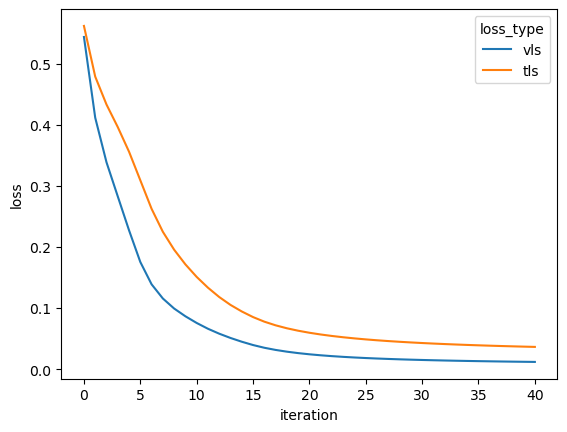

In [18]:
y_key = 'vls'
sns.lineplot(data=plot_data, x='iteration', y='loss', hue='loss_type')

In [44]:
df_param = pd.read_csv(r'results/fertility_params.csv')

In [45]:
converged = df_param['converged'].values.tolist()
converged_new = []
for cs in converged:
    cs = cs.replace('[', '').replace(']', '').split(', ')
    c_bools = [c == 'True' for c in cs]
    converged_new.append(c_bools)
df_param['converged'] = converged_new

In [46]:
df_param['converged_final'] = df_param.converged.apply(lambda x: all(x))

In [48]:
df_param.columns

Index(['model', 'test_score', 'test_score_mean', 'test_score_std', 'fit_time',
       'fit_time_mean', 'fit_time_std', 'score_time', 'score_time_mean',
       'score_time_std', 'parameter_num', 'hidden_layer_sizes',
       'activation_function', 'learning_rate', 'converged',
       'validation_losses', 'training_losses', 'num_iter', 'converged_final'],
      dtype='object')

Text(0.5, 1.0, 'Mean fitting times over converged models')

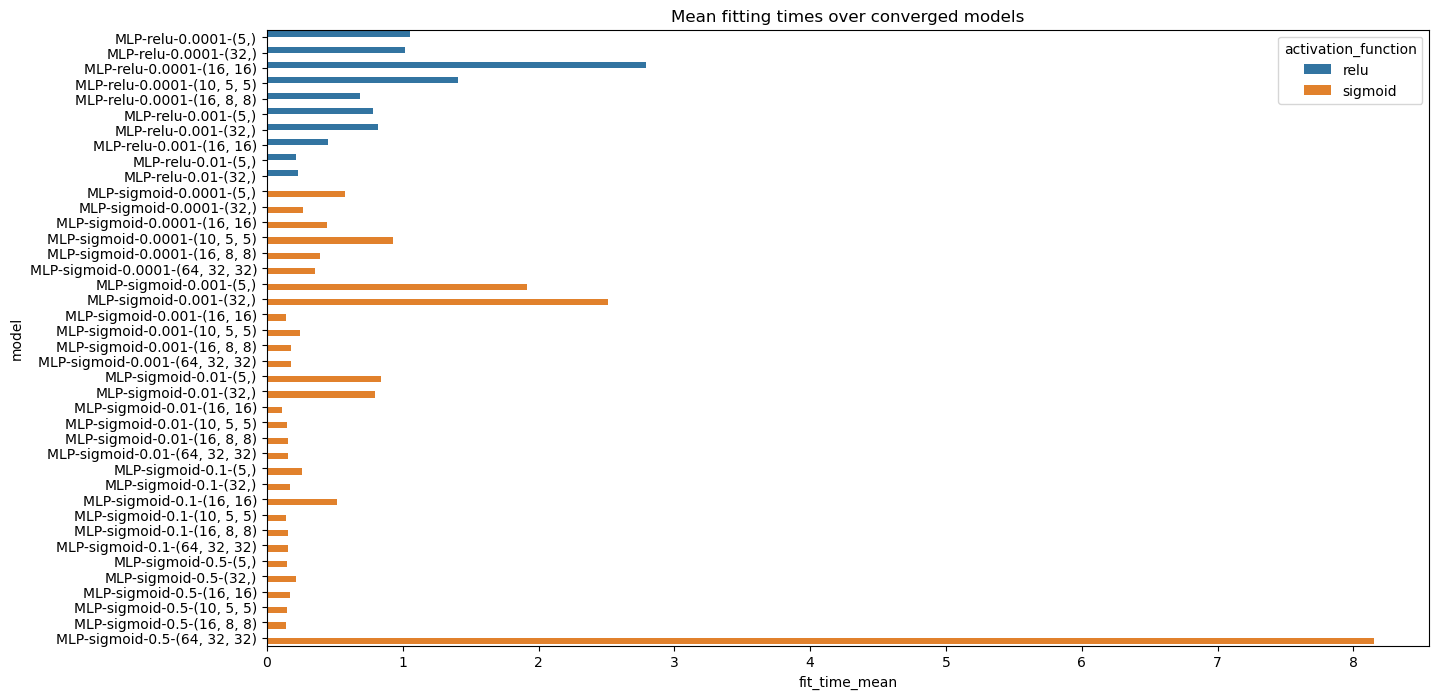

In [60]:
_, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=df_param[df_param.converged_final], y='model', x='fit_time_mean', hue='activation_function', ax=ax, errorbar=())
ax.set_title('Mean fitting times over converged models')


## Comparison 